<a href="https://colab.research.google.com/github/guidoapuzzo/Complex-Systems/blob/main/1_Random_Walks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Random walks


This notebook is focusing on random walks and stochastic processes.
The random walk is a simple model in which a walker decides to at random the direction in which to move. Consider a d-dimensional space and a walker placed at the origin with coordinates $(x_1,...x_d)=(0,...0)$. At each time step, we pick a direction $i=1,...d$ at random and move either forward ($x_i = x_i +1$) or backwards ($x_i=x_i-1$) with equal probabilities. We then repeat the process.

The notebook is divided in three parts exploring different variants of the random walk and using what we learned to study a practical example.

- 1.A Return to the origin of a random walk
- 1.B Self avoiding walks
- 1.C Analyzing stock market fluctuations


In [ ]:
# multidimensional arrays
import numpy as np

# inline plots
import matplotlib.pyplot as plt
%matplotlib inline

# nicer figures
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# 1.A Return to the origin


For a *finite* random walk of (large) length $n$, it is known that the expected number of returns to the origin $T_n$ scales like follows:
$$
\left\langle T_n \right\rangle \sim \left\{
\begin{array}{ll}
\sqrt{n} & d=1 \\
\log(n) & d=2 \\
C_d & d\geq 3
\end{array}
\right.
$$


<img src="attachment:image.png" width="600">

Notice that for $d \geq 3$, $\left\langle T_n \right\rangle$ does **not** grow with $n$, which must mean that the walker somehow "escapes" and never returns back to the origin. The probability of return to the origin is less than 1! For an infinite-length random walk, indeed the probability of returning to the origin $\rho$ is seen to be

$$
\rho \sim \left\{
\begin{array}{ll}
1 & d=1 \\
1 & d=2 \\
<1 & d\geq 3
\end{array}
\right.
$$

The *intuitive* explanation of this amazing fact is that, as the dimension $d$ grows, there are "more directions available", and so more chances for the walker to "get lost" and never return to the origin. There is of course a formal proof as well, but you will perform a **computational verification** of these facts, which is no substitute for a formal proof but is often all we can do!

## Generating Random Walks


### Exercise 1.1
Write a function that generates a random walk of given length in $d$ dimensions. Your random walker should move as follows:

+ At each time-step, the walker moves only in one direction.
+ At each time-step, the walker moves only by -1 or +1

Your function should return a numpy array of shape (`length`, `dim`). Example:
```python
>>> # create a RW of length 10 in dimension 3
>>> traj = get_traj(length=10, dim=3)
>>> # check that the output has the right shape
>>> traj.shape
(10, 3)
```

In [ ]:
def get_traj(length=100, dim=2):
    """Generate a RW in d dimensions

    Parameters
    ----------
    length: int
        Length of the RW.
    dim: int
        Dimension of the RW


    Returns
    -------
    traj : np.ndarray, (length, dim)
        The positions of the RW.

    Notes
    -----
    At each time-step, the walker moves in only one direction.
    At each time-step, the walker moves by -1 or +1
    """
    # Initialize the trajectory with the starting point at the origin
    # (array with length = rows (one for each step in the random walk) and dim = columns (one for each dimension))
    traj = np.zeros((length, dim))

    # Generate the random walk
    for i in range(1, length):
        # Copy the position from the previous step
        traj[i] = traj[i-1]

        # Choose a random dimension to move in
        d = np.random.randint(dim)

        # Choose a random direction to move in: -1 or +1
        direction = np.random.choice([-1, 1])

        # Update the position in the chosen dimension
        traj[i, d] += direction

    return traj

### Verification
To make sure that your function works correctly, execute the following cell. Notice the use of `assert` statements: execution should fail if something goes wrong. If everything is fine, nothing should happen.

In [ ]:
# basic checks for your RW generator
for dim in range(1, 5):
    for length in [10, 100, 200, 500]:
        traj = get_traj(length=length, dim=dim)
        # make sure traj has the right shape
        assert traj.shape == (length, dim)
        # make sure all steps are -1 or 1 in only one direction
        assert np.all(np.sum(np.diff(traj, axis=0) != 0, axis=1) == np.ones(length - 1))

### Exercise 1.2
Plot a random walk of length $10^4$ for $d=1$ (time in x-axis, position in y-axis) and $d=2$ (x,y components in x,y-axis). Remember to use **axis labels**.

In [ ]:
# it is better if you use one cell to generate the random walks, and a second cell to plot them
RW_1d = get_traj(10**4, 1)
RW_2d = get_traj(10**4, 2)

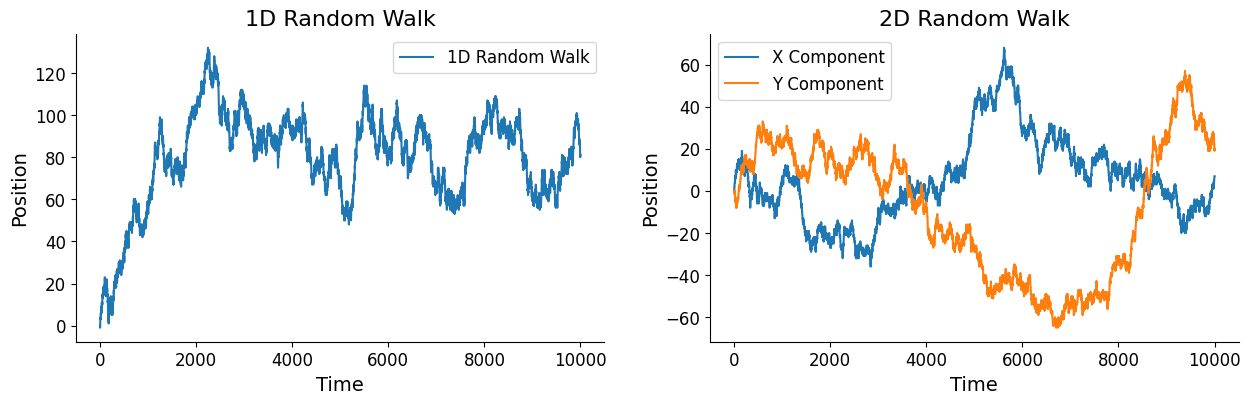

In [ ]:
# We generate a figure with two subplots, called axis in matplotlib.
#
# To use the left subplot, we do
# ax1.plot(...)
#
# while to use the right subplot, we do
# ax2.plot(..)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Plot the 1D random walk on the left subplot
ax1.plot(RW_1d, label='1D Random Walk')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title('1D Random Walk')
ax1.legend()

# Plot the 2D random walk on the right subplot
ax2.plot(RW_2d[:, 0], label='X Component')
ax2.plot(RW_2d[:, 1], label='Y Component')
ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.set_title('2D Random Walk')
ax2.legend()

# Display the figure
plt.show()

## Counting the number of returns to the origin
Since we are interested in how **the expected number of returns to the origin** scales with the RW length, we don't need to store the whole trajectory of each simulation (we will be performing many simulations!).

### Exercise 1.3
Write a function that generates a RW of given length and dimension (calling `get_traj`), and returns the number of times it returned to the origin. To count the number of returns to the origin, you might need to use the following functions:
```python
np.all()
np.zeros()
```

In [ ]:
def get_num_returns(length, dim):
    # generate a RW of given length and dimension
    traj = get_traj(length, dim)
    # count how many times it goes through the origin
    num_returns_to_origin = np.sum(np.all(traj == 0, axis=1)) #checks each position in the trajectory to see if all its coordinates are 0 (which means the position is the origin)
                                                              #returns a Boolean array of the same length as the trajectory, with True at the indices where the position is the origin and False elsewhere.
                                                              #np.sum function is then used to count the number of True values in this array

    return num_returns_to_origin

### Exercise 1.4
Write a function that computes the expected number of returns to the origin for a given length and dimension. Your function will call `get_num_returns()`, and should have an additional parameter that sets the sample size.

In [ ]:
def get_average_num_returns(length, dim, num_trajs=200):
    # Intialize a variable to store the total number of returns
    total_returns = 0
    # Generate the specified number of random walks
    for _ in range(num_trajs):
        # Get the number of returns to the origin for this rw
        num_returns = get_num_returns(length, dim)

        # Add the number of returns to the total
        total_returns += num_returns

    # Compute the average number of returns
    average_num_returns = total_returns/num_trajs

    return average_num_returns

## Comparing with analytical results
We are now ready to compare our analytical results with numerical simulations! We want to plot the expected number of returns to the origin as a function of the RW length. To do this, it is useful to first define an array of RW lengths.

In [ ]:
# define range of RW lengths
length_min = 10
length_max = 100000
# generate points logarithmically spaces
# and convert them to integers
length_array = np.array([
    int(x)
    for x in np.geomspace(length_min, length_max, num=20)
])

(tip: if your RW generating function is not very efficient, you might want to decrease `length_min`)  

Executing the following cell will run all simulations for $d=1$


In [ ]:
dim=1
num_returns_array = np.array([
    get_average_num_returns(length=length, dim=dim)
    for length in length_array
])

### Exercise 1.5
Plot the average number of returns to the origin of a 1D RW as a function of the RW length, together with the expected theoretical result. Do your results verify the $n^{1/2}$ scaling? **Tip** Use double-logarithmic scales in your plot. Remember to include label axis, and a legend!

Text(0.5, 1.0, 'Expected Number of Returns to Origin for 1D Random Walk')

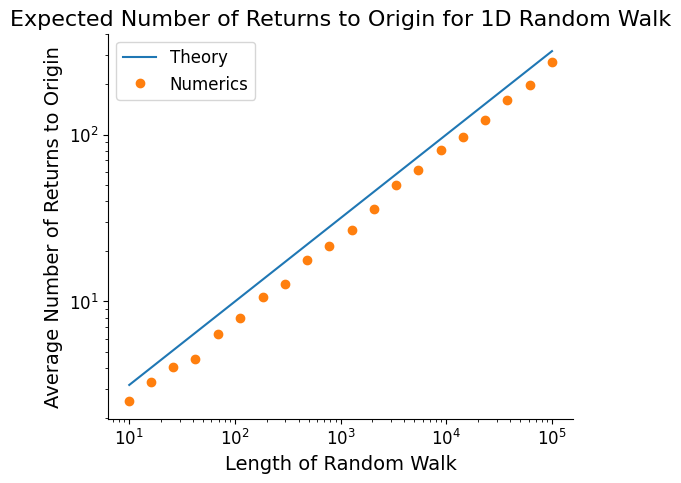

In [ ]:
# Define the theoretical result
theory = np.sqrt(length_array)

# Generate the figure
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Plot the theoretical result
ax.loglog(length_array, theory, label="Theory")

# Plot the numerical result
ax.loglog(length_array, num_returns_array, 'o', label="Numerics")

# Add axis labels
ax.set_xlabel('Length of Random Walk')
ax.set_ylabel('Average Number of Returns to Origin')

# Add a legend
ax.legend()

# add a title (e.g. that says what dimension we used)
ax.set_title('Expected Number of Returns to Origin for 1D Random Walk')

### Exercise 1.6
Plot the average number of returns to the origin of a 2D RW as a function of the RW length. Do your results verify the $log(n)$ scaling? What are the best axis scales to use in this case?

In [ ]:
# do the simulations for d=2
dim=2
num_returns_array_2d = np.array([
    get_average_num_returns(length=length, dim=dim)
    for length in length_array
])

In [ ]:
import scipy
from scipy.optimize import minimize

# Define error function
def error_function(prefactor):
    theory_2d = prefactor * np.log(length_array)
    error = np.sqrt(np.mean((num_returns_array_2d - theory_2d)**2))
    return error

# Use scipy.optimize.minimize to find best prefactor
result = minimize(error_function, x0=0.5)

# Store best prefactor in result.x
best_prefactor = result.x[0]
print(best_prefactor)

0.41998607200994686


Text(0.5, 1.0, 'Expected Number of Returns to Origin for 2D Random Walk')

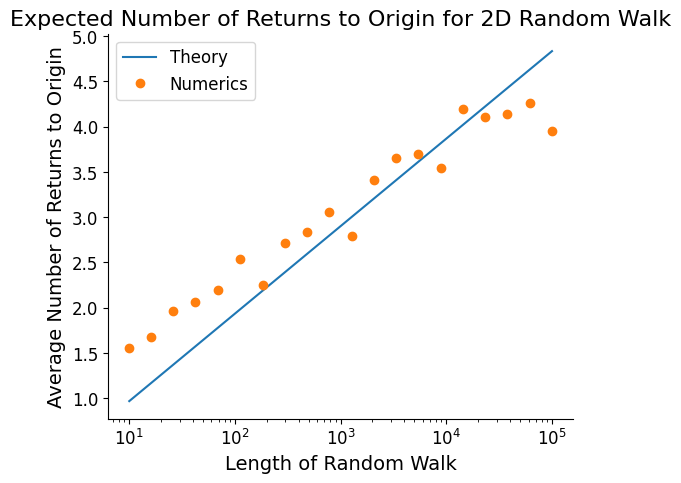

In [ ]:
# plot the numerical results + theory
# Define the theoretical result
theory_2d = best_prefactor * np.log(length_array)

# Generate the figure
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Plot the theoretical result
ax.semilogx(length_array, theory_2d, label="Theory")

# Plot the numerical result
ax.semilogx(length_array, num_returns_array_2d, 'o', label="Numerics")

# Add axis labels
ax.set_xlabel('Length of Random Walk')
ax.set_ylabel('Average Number of Returns to Origin')

# Add a legend
ax.legend()

# Add a title
ax.set_title('Expected Number of Returns to Origin for 2D Random Walk')

### Exercise 1.7
Show numerically that, for $d=3$ and $d=4$, the expected number of returns to the origin is **constant**.

In [ ]:
# Do the simulations for d=3
dim = 3
num_returns_array_3d = np.array([
    get_average_num_returns(length=length, dim=dim)
    for length in length_array
])

# Do the simulations for d=4
dim = 4
num_returns_array_4d = np.array([
    get_average_num_returns(length=length, dim=dim)
    for length in length_array
])

In [ ]:
print("Average number of returns to origin for 3D random walk:", np.mean(num_returns_array_3d))
print("Average number of returns to origin for 4D random walk:", np.mean(num_returns_array_4d))

Average number of returns to origin for 3D random walk: 1.4665000000000001
Average number of returns to origin for 4D random walk: 1.2272500000000002


# 1.B Self-Avoiding Walks
Self-avoiding walks (SAW) are simply random walks in a regular lattice with the additional constraint that no point can be visited more than once. That is, SAWs cannot intersect themselves. The most well-known application of SAW is to model linear polymers, where obviously two monomers cannot occupy the same space (excluded volume effect).


You can read more about self-avoiding walks in this nice introduction by Gordon Slade:

[Self-Avoiding Walks, by Gordon Slade](https://www.math.ubc.ca/~slade/intelligencer.pdf)

## Simulating Self-Avoiding Walks
Generating a SAW is not trivial. If you try to generate a SAW stochastically, that is, one step at a time, you will miserably fail: your walker might get into traps (configurations with no allowed movements), and if it does you will have to discard your simulation. It turns out you will have to discard your simulation *really* often, so that for large lengths, you will basically never find a valid path. In addition, the paths you will find for short lengths will not come up with the right probabilities. Bear in mind that we want to **uniformly sample** the set of SAW of given length $n$, SAW($n$). That is, we want that all paths from SAW($n$) are generated with the same probability.

The solution is to use a Monte Carlo algorithm that, given one element $\alpha \in \text{SAW}(n)$, generates a new one $\beta \in \text{SAW}(n)$ with some probability $P_{\alpha \beta}$. If in addition our algorithm satisfies **detailed balance** and is **ergodic**, then we known that it will converge to the equilibrium distribution (the uniform distribution in our case).


## The pivot algorithm
We will implement the pivot algorithm, which is simple, effective, and satisfies detailed balance and ergodicity. You can read about the details of the pivot algorithm here:

[The Pivot Algorithm: A Highly Efficient Monte Carlo Method for the Self-Avoiding Walk](https://link.springer.com/article/10.1007/BF01022990)


Given a self-avoiding walk of length $n$, the pivot algorithm generates the next walk $\beta \in \text{SAW}(n)$ as follows:

1. **Choose a point of $\alpha$ at random**, splitting the path in two bits: the head (from the origin to the chosen point) and the tail (from the chosen point to the end of the path). Notice that both the head and the tail are SAWs.
2. **Apply a transformation to the tail**, leaving the head intact. The transformation must be an orthoganl transformation that leaves the regular lattice intact (so, either a reflection or a $90º, 180º$ or $270º$ rotation). For simplicity, we will use only **rotations** (read the paper to see why this is ok).
3. **Check if the new path is self-avoiding**. If so, return it. Otherwise, return the original path.

Iterating these steps one obtains a **Markov** chain of SAWs: $\alpha_1 \to \alpha_2 \to \dots \to \alpha_M $. Notice that $\alpha_i$ are not uncorrelated, but because the algorithm satisfies detailed balance and is ergodic, we know that it approaches the equilibrium distribution. This means that we can use our Markov chain to compute **expected values** as long as it is long enough.

## Implementing the pivot step in 2D
To implement the **pivot algorithm** in 2D, we will write one function that does steps 1 and 2, and another function that does step 3. We will also need a function to generate standard 2D random walks.

### Exercise 1.8
Write a function `get_traj` that generates a 2D random walk of given length.

In [ ]:
def get_traj(length):
    """Generate a 2D random walk of given length"""
    # Initialize the trajectory with the starting point at the origin
    traj = np.zeros((length, 2))

    # Generate the random walk
    for i in range(1, length):
        # Copy the position from the previous step
        traj[i] = traj[i-1]

        # Choose a random direction: up, down, left, or right
        direction = np.random.choice(['up', 'down', 'left', 'right'])

        if direction == 'up':
            traj[i, 1] += 1
        elif direction == 'down':
            traj[i, 1] -= 1
        elif direction == 'left':
            traj[i, 0] -= 1
        elif direction == 'right':
            traj[i, 0] += 1

    return traj

### Exercise 1.9
Write a function `pivot_traj` that, given a 2D random walk, performs steps 1 and 2 of the pivot algorithm. Some useful functions:
```python
np.random.randint()
np.concatenate()
```
You might also want to multiply matrices using the `@` operator:
```python
>>> a = np.array([[1, 2], [3, 4], [5, 6]])
>>> b = np.array([1, 1])
>>> a @ b
array([ 3,  7, 11])
```


In [ ]:
def pivot_traj(traj):
    """Apply a random rotation to part of a RW."""

    # choose the pivot
    pivot_index = np.random.randint(len(traj))
    pivot_point = traj[pivot_index]

    # split head and tail
    traj_head = traj[:pivot_index]
    traj_tail = traj[pivot_index:] - pivot_point  # Subtract pivot_point to rotate around the origin

    # define the rotation matrices
    symmetries = [
        # 90 deg rotation
        np.array([[ 0, -1], [ 1, 0]]),
        # 180 deg rotation
        np.array([[ -1, 0], [ 0, -1]]),
        # 270 deg rotation
        np.array([[ 0, 1], [ -1, 0]])
    ]

    # choose one rotation at random
    symmetry = symmetries[np.random.randint(3)]

    # apply the transformation to the tail
    new_tail = (symmetry @ traj_tail.T).T + pivot_point  # Add pivot_point to move back to original position

    # join the old head with the new tail
    new_traj = np.concatenate((traj_head, new_tail))

    return new_traj

### Exercise 1.10
Write a function that counts the number of self-intersections of a RW. Notice that SAWs have 0 self intersections, so that will solve step 3 of the pivot algorithm, but will also be useful to generate the initial condition. One way of approaching this exercise is to count how many *different* points the path visits.

In [ ]:
def count_self_intersections(traj):
    """Count the number of self-intersections of a RW"""

    # Convert trajectory to a set of tuples (each tuple represents a point in the trajectory)
    traj_set = set(map(tuple, traj))

    # Number of self-intersections is the difference between the length of the trajectory and the number of unique points
    num_self_intersections = len(traj) - len(traj_set)

    return num_self_intersections

### Exercise 1.11
Verify that your `count_self_intersecitons` function works properly by using short trajectories for which you know the answer.

In [ ]:
# Define a trajectory with no self-intersections
traj1 = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
print(count_self_intersections(traj1))

# Define a trajectory with one self-intersection
traj2 = np.array([[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]])
print(count_self_intersections(traj2))

# Define a trajectory with two self-intersections
traj3 = np.array([[0, 0], [0, 1], [1, 1], [1, 0], [0, 0], [0, 1]])
print(count_self_intersections(traj3))


0
1
2


## Generating the initial condition
You might have noticed that the pivot algorithm requires an element of SAW($n$) as starting condition, to then generate a Markov chain easily. But how do you get this first element? We will use the following strategy:
1. Generate a standard 2D random walk, and count the number of self intersections.
2. Apply the pivot transformation to get a new 2D random walk, and count the number of self-intersections-
3. If the number of self-intersections has decreased or not changed, keep the new path. Else, keep the old one.
4. Go to 2, till the number of self-intersections is 0.

### Exercise 3.12
Write a function `get_first_SAW` that generates a SAW of given length

In [ ]:
def get_first_SAW(length, max_tries=1000000):
    for _ in range(max_tries):
        # Generate a standard 2D random walk
        traj = get_traj(length)

        # Count the number of self-intersections
        num_self_intersections_old = count_self_intersections(traj)

        # Apply the pivot transformation
        new_traj = pivot_traj(traj)

        # Count the number of self-intersections in the new trajectory
        num_self_intersections_new = count_self_intersections(new_traj)

        # If the number of self-intersections has decreased or not changed, keep the new path
        if num_self_intersections_new <= num_self_intersections_old:
            traj = new_traj

        # If the number of self-intersections is 0, return the trajectory
        if num_self_intersections_new == 0:
            return traj

    # If no SAW is found within max_tries attempts, raise an exception
    raise ValueError(f"Failed to generate a self-avoiding walk of length {length} within {max_tries} tries.")


### Exercise 1.13
Generate and plot some 2D SAWs of different lengths. Be carefull, raise the length slowly! You can measure how long a cell takes executing using the `%%time` magic at the top of a cell.

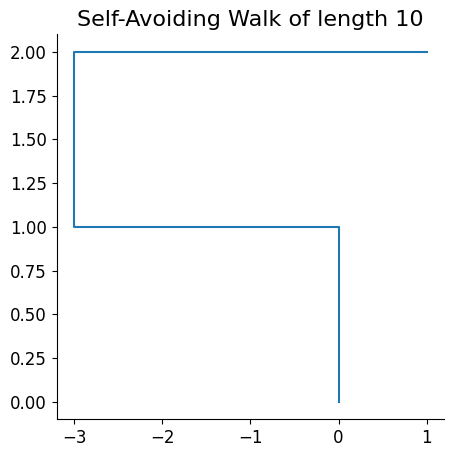

CPU times: user 246 ms, sys: 101 ms, total: 347 ms
Wall time: 235 ms


In [ ]:
%%time
# Generate a SAW of length 10
traj = get_first_SAW(10)

# Plot the SAW
plt.figure(figsize=(5, 5))
plt.plot(traj[:, 0], traj[:, 1])
plt.title('Self-Avoiding Walk of length 10')
plt.show()

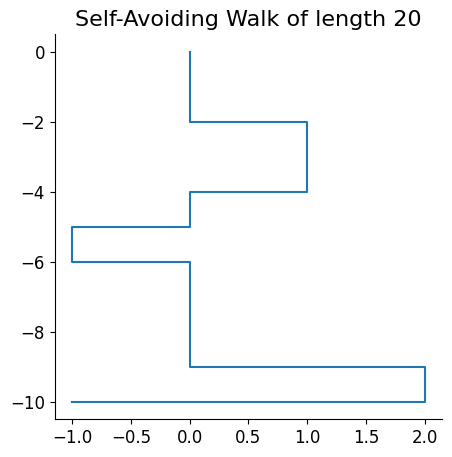

CPU times: user 406 ms, sys: 104 ms, total: 510 ms
Wall time: 389 ms


In [ ]:
%%time

traj = get_first_SAW(20)


plt.figure(figsize=(5, 5))
plt.plot(traj[:, 0], traj[:, 1])
plt.title('Self-Avoiding Walk of length 20')
plt.show()

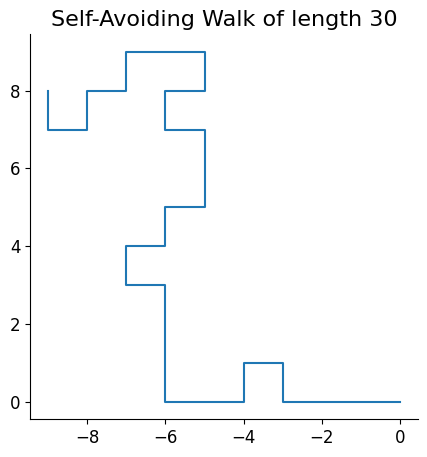

CPU times: user 27 s, sys: 193 ms, total: 27.1 s
Wall time: 27.1 s


In [ ]:
%%time

traj = get_first_SAW(30)


plt.figure(figsize=(5, 5))
plt.plot(traj[:, 0], traj[:, 1])
plt.title('Self-Avoiding Walk of length 30')
plt.show()

### Exercise 1.14
Write a function `get_next_SAW` that, given a SAW, generates another SAW using the pivot algorithm. Your function should check that the input RW is really a SAW. Remember the steps:

1. Apply the pivot transformation
2. Check if the new path is self-avoiding. **If so, return it. Otherwise, return the original path.**

In [ ]:
def get_next_SAW(traj):
    # make sure input traj is SAW
    assert count_self_intersections(traj) == 0, "Input trajectory is not a self-avoiding walk (SAW)."

    # pivot step
    proposed_traj = pivot_traj(traj)

    # count intersections
    num_intersections = count_self_intersections(proposed_traj)

    # if it's a SAW
    if num_intersections == 0:
        return proposed_traj

    # if not
    else:
        return traj

### Mean Squared Displacement in SAW
A quantity of interest in RWs is the mean squared displacement, which is simply the (squared) distance between the endpoints of the walk. Usually, one writes

$$
\left\langle X(n)^2 \right\rangle \sim n^{2 \nu}
$$

As you know, for a standard RW of $n$ steps, the mean-squared displacement scales like $n$, so $\nu=1/2$. However, the exponent for SAW is **different**! Althought it has not been formally proven (still), it is believed that the exponent for SAW is $\nu=3/4$. That is, for a self-avoiding random walk, the mean squared displacement scales as $n^{3/2}$.

### Exercise 1.15
Explain why it makes sense that the mean-squared displacement exponent of SAW is **greater** than that of standard RW.

It makes sense because of the constraint imposed by self-avoidance. Since in self-avoiding walks the walker cannot revisit any point it has already visited, this significantly restricts the available pathways. As the walk progresses, the walker must explore new regions of space to avoid self-intersections, leading to a more exploratory behavior compared to standard random walks. This increased exploration allows the walker to cover a larger area of space for a given number of steps, resulting in a faster increase in the mean-squared displacement with the number of steps.

### Exercise 1.16
Verify numerically the scaling of the mean-squared displacement of SAW. Notice that you don't need to store all the SAWs, just the endpoints. You could follow this scheme:

1. Generate a first SAW with your `get_first_SAW()` function
2. Generate the next SAW using your `get_next_SAW()` function, and store the endpoint.
3. Iterate step 2 for as many steps as required
4. Compute the average mean-squared displacement of the stored endpoints

Then repeating steps 1-4 for different lengths, and plot the results in double-logarithmic axis. Compare your results with the theoretical exponent. Do they agree?

In [ ]:
# Define function to compute mean squared displacement
def mean_squared_displacement(endpoints):
    displacements = np.sum(endpoints**2, axis=1)  # Squared distance for each endpoint
    return np.mean(displacements)  # Average mean squared displacement

In [ ]:
# Define function to perform numerical verification
def verify_scaling(max_length, num_trials=100):
    lengths = np.arange(1, max_length + 1)
    msd_values = []

    for length in lengths:
        squared_displacements = []

        for _ in range(num_trials):
            # Generate first SAW
            traj = get_first_SAW(length)
            endpoint = traj[-1]  # Store endpoint

            # Generate next SAWs and store endpoints
            for _ in range(length):
                traj = get_next_SAW(traj)
                endpoint = traj[-1]

            squared_displacements.append(endpoint**2)  # Store squared endpoint

        msd = np.mean(np.array(squared_displacements), axis=0)  # Compute mean squared displacement
        msd_values.append(msd)

    return lengths, np.array(msd_values)

In [ ]:
# Perform numerical verification
max_length = 100
lengths, msd_values = verify_scaling(max_length)

In [ ]:
# Plot the results on a double-logarithmic axis
plt.figure(figsize=(8, 6))
plt.loglog(lengths, msd_values, 'o-', label='Numerical Results')
plt.loglog(lengths, lengths**(3/2), label='Theoretical Exponent (ν=3/2)', linestyle='--')
plt.xlabel('Length of Self-Avoiding Walk')
plt.ylabel('Mean Squared Displacement')
plt.title('Numerical Verification of Mean Squared Displacement Scaling in SAW')
plt.legend()
plt.grid(True)
plt.show()

# 1.C Analysing stock market fluctuations

Here will we will analyze stock market time series using the same tools as used for random walks. The data here represent the historical series of the SP500 index (the Standard and Poor's 500 index, a weighted average of the prices of five hundred large companies in the United States stock-market) from 02/01/1983 to 10/18/2019 with a frequency 1 minute (data source SANTAMARIA, CESAR (2020), “S&P 500 Index”, Mendeley Data, V1, doi: 10.17632/smvny46yrg.1
https://data.mendeley.com/datasets/smvny46yrg/1).

The goal of the exercise is to compare the SP500 series to a random walk and highlight the differences.


In [ ]:
import pandas as pd

In [ ]:
import seaborn as sns

In [ ]:
# load the data.
sp500=pd.read_csv("../DATA/SPX.txt")

### Exercise 1.17 Data exploration

First plot the index series (you can use one of the columns "Open","High" "Low" "Close"), compute the instantaneous price variations (the derivative of the curve), estimate its distribution and compare it with a Gaussian. How good is the Gaussian assumption?     


In [ ]:
# Plot the index series
plt.figure(figsize=(10, 6))
plt.plot(sp500['Date'], sp500['Close'], color='blue')
plt.title('S&P 500 Index Series')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
plt.show()

In [ ]:
# Compute instantaneous price variations (derivative of the curve)
price_variations = np.diff(sp500['Close'])

In [ ]:
# Estimate the distribution of price variations
mu, std = norm.fit(price_variations)

In [ ]:
# Plot the histogram of price variations along with the fitted Gaussian distribution
plt.figure(figsize=(8, 6))
plt.hist(price_variations, bins=50, density=True, alpha=0.6, color='g', label='Price Variations Histogram')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Fitted Gaussian Distribution')
plt.title('Distribution of Instantaneous Price Variations')
plt.xlabel('Price Variation')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Assess the goodness of fit for the Gaussian assumption
print("Gaussian Distribution Parameters:")
print("Mean:", mu)
print("Standard Deviation:", std)

### Exercise 1.18 Multiplicative processes
It is reasonable to assume that fluctuations in price variations  depend on the value of the price. This leads to a multiplicative process:

$z(t+dt) = z(t) \eta(t)$ where $\eta(t)$ is uncorrelated noise.

If we define $x(t)=\log z(t)$, then $x(t)$ follows a random walk:

$x(t+dt) = x(t) + f(t)$, where $f=\log \eta$.

Compute the $\log$ of the SP500 index, plot it as well as its derivative. Repeat the analysis of the previous exercise and compare the distribution of $f$ with a Gaussian. Explore which statistical distribution would best describe the signal.


In [ ]:
# Compute the logarithm of the SP500 index
log_sp500 = np.log(sp500['Close'])

In [ ]:
# Plot the logarithm of the index series
plt.figure(figsize=(10, 6))
plt.plot(sp500['Date'], log_sp500, color='blue')
plt.title('Logarithm of S&P 500 Index Series')
plt.xlabel('Date')
plt.ylabel('Logarithm of Index Value')
plt.grid(True)
plt.show()

In [ ]:
# Compute the derivative of the logarithm of the index series
log_sp500_diff = np.diff(log_sp500)

In [ ]:
# Plot the derivative of the logarithm of the index series
plt.figure(figsize=(10, 6))
plt.plot(sp500['Date'][1:], log_sp500_diff, color='green')
plt.title('Derivative of Logarithm of S&P 500 Index Series')
plt.xlabel('Date')
plt.ylabel('Derivative of Logarithm of Index Value')
plt.grid(True)
plt.show()

In [ ]:
# Estimate the distribution of f (log of noise)
mu_f, std_f = norm.fit(log_sp500_diff)

In [ ]:
# Plot the histogram of f along with the fitted Gaussian distribution
plt.figure(figsize=(8, 6))
plt.hist(log_sp500_diff, bins=50, density=True, alpha=0.6, color='g', label='f (Noise) Histogram')
xmin, xmax = plt.xlim()
x_f = np.linspace(xmin, xmax, 100)
p_f = norm.pdf(x_f, mu_f, std_f)
plt.plot(x_f, p_f, 'k', linewidth=2, label='Fitted Gaussian Distribution')
plt.title('Distribution of f (Log of Noise)')
plt.xlabel('f (Log of Noise)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Assess the goodness of fit for the Gaussian assumption
print("Gaussian Distribution Parameters for f (Log of Noise):")
print("Mean:", mu_f)
print("Standard Deviation:", std_f)

### Exercise 1.19 Mean square displacements of the SP500 index

Working with the $\log$ of the index timeseries, study the time dependence of mean-square displacement:

$$ W(t,t')=\langle (z(t) - z(t'))^2 \rangle $$

to perform the average, assume that the $W(t,t')$ only depends on $t-t'$. Plot the data on a log-log scale. How does this compare with the prediction of the random walk model?

One might assume that data series displays a linear trend. To remove the trend, fit a linear function to the data and then subtract the result:
$z'(t) = z(t)-at-b$.

Study again the time dependence of mean-square displacements.   



### Exercise 1.20 Return to the origin of the SP500 index

Study the return to the origin of the $\log$ SP500 index considering both the signal as it is and the detrended one. How does this compare with the predictions of the random walk?
